In [1]:
from time import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' 

from keras.layers import Input, Dense, Lambda, Conv2D, Conv2DTranspose, Activation, Flatten, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras import backend as K
from keras import metrics

Using TensorFlow backend.


In [31]:
class VAE():
    stdEps = 1.0
    
    def __init__(self, 
                 dimInput, 
                 layerDense=[64, 2], actDense='relu',
                 ratRecon=0.998
                ):
        
        # Initialize some setting 
        self.dimInput = dimInput # dimInput is width*height
        self.inputs = Input(shape=(dimInput,)) 
        self.dimEncode = layerDense[-1]
        self.ratRecon = ratRecon
        
        self.encoding(layerDense, actDense)
        
        self.decoding(layerDense, actDense)
        
        self.autoencoder = Model(self.inputs, self.decoder(self.encoder(self.inputs)), name='autoencoder')

        
    def encoding(self, layerDense, actDense):
        dimEncode = self.dimEncode
        x = self.inputs

        # Stack of Dense layers
        for numFilt in layerDense[:-1]:
            x = Dense(numFilt, activation=actDense)(x)
        self.zMean = Dense(self.dimEncode)(x)
        self.zSigmaLog = Dense(self.dimEncode)(x) # log for linear dense

        # Construct the latent as the output and build the encorder pipeline
        z = Lambda(self.sampling)([self.zMean, self.zSigmaLog])
        self.encoder = Model(self.inputs, z, name='encoder')

        
    def decoding(self, layerDense, actDense):
         # Build the Decoder Model
        inputLatent = Input(shape=(self.dimEncode,), name='decoder_input')
        x = inputLatent
        for numFilt in layerDense[-2::-1]:
            x = Dense(numFilt, activation=actDense)(x)
            
        # Reconstruct the pixels as the output and build the decorder pipeline
        outputs = Dense(dimInput, activation='sigmoid', name='decoder_output')(x)
        self.decoder = Model(inputLatent, outputs, name='decoder')
        
        
    def sampling(self, args):
        zMean, zSigmaLog = args
        epsilon = K.random_normal(shape=(K.shape(zMean)[0], self.dimEncode),
                                  mean=0., stddev=stdEps)
        return zMean + K.exp(zSigmaLog) * epsilon  
        
        
    def lossVAE(self, args):
        zMean, zSigmaLog = args
        def loss(tensorInput, tensorDecode):
            lossRecon =  metrics.binary_crossentropy(K.flatten(tensorInput), K.flatten(tensorDecode))
            lossKL = - 0.5 * K.sum(1 + 2 * zSigmaLog - K.square(zMean) - K.square(K.exp(zSigmaLog)), axis=-1)
    #         lossKL = - 0.5 * K.mean(1 + zSigmaLog - K.square(zMean) - K.exp(zSigmaLog), axis=-1)
            return ratRecon * lossRecon + (1 - ratRecon) * lossKL
        return loss
    
    
    def train(self,
              xTrain, xValid,
              numEpochs=50, sizeBatch=32, nameOptim='adam',
              tempPathBest=None, patience=3,
             ):
        
        self.autoencoder.compile(optimizer=nameOptim, loss=self.lossVAE([self.zMean, self.zSigmaLog]))

        if tempPathBest is None:
            callbacks = None
        else:
            cbEarlyStop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
            chkpt = tempPathBest + 'Conv_AutoEncoder.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
            cbCheckPoint = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
            callbacks = [cbEarlyStop, cbCheckPoint]
        
        
        # Train the autoencoder
        tic = time()
        history = self.autoencoder.fit(xTrain, xTrain,
                                       epochs=numEpochs,
                                       batch_size=sizeBatch, shuffle=True,
                                       callbacks=callbacks,
                                       validation_data=(xValid, xValid)
                                      )
        timeTrain = time() - tic
        
        return history, timeTrain

In [32]:
class ConvVAE():
    stdEps = 1.0
    
    def __init__(self, 
                 dimInput, 
                 layerConv=[8, 32], sizeKernel=3, strides=2, actConv='relu', padding='same',
                 layerDense=[64, 2], actDense='relu',
                 ratRecon=0.998):
        
        # Initialize some setting 
        self.dimInput = dimInput # dimInput is (width, height, channels)
        self.inputs = Input(shape=(dimInput)) 
        self.dimEncode = layerDense[-1]
        self.ratRecon = ratRecon
        
        self.encoding(layerConv, sizeKernel, strides, actConv, padding,
                 layerDense, actDense,
                )
        
        self.decoding(layerConv, sizeKernel, strides, actConv, padding,
                 layerDense, actDense,
                )
        
        self.autoencoder = Model(self.inputs, self.decoder(self.encoder(self.inputs)), name='autoencoder')
        

        
    def encoding(self, 
                 layerConv, sizeKernel, strides, actConv, padding,
                 layerDense, actDense,
                ):
        dimEncode = self.dimEncode
        x = self.inputs
        # Stack of Conv2D layers
        for filters in layerConv:
            x = Conv2D(filters=filters,
                       kernel_size=sizeKernel,
                       strides=strides,
                       activation=actConv,
                       padding=padding)(x)

        # Shape info needed to build Decoder Model
        self.shape = K.int_shape(x)

        # Stack of Dense layers
        x = Flatten()(x)
        for numFilt in layerDense[:-1]:
            x = Dense(numFilt, activation=actDense)(x)
        self.zMean = Dense(dimEncode)(x)
        self.zSigmaLog = Dense(dimEncode)(x) # log for linear dense

        # Construct the latent as the output and build the encorder pipeline
        z = Lambda(self.sampling)([self.zMean, self.zSigmaLog])
        self.encoder = Model(self.inputs, z, name='encoder')

        
    def decoding(self,
                 layerConv, sizeKernel, strides, actConv, padding,
                 layerDense, actDense,
                ):
        
        shape = self.shape
         # Build the Decoder Model
        inputLatent = Input(shape=(self.dimEncode,), name='decoder_input')
        x = inputLatent
        for numFilt in layerDense[-2::-1]:
            x = Dense(numFilt, activation=actDense)(x)
            
        x = Dense(shape[1] * shape[2] * shape[3])(x)
        x = Reshape((shape[1], shape[2], shape[3]))(x)

        # Stack of Transposed Conv2D layers
        for numFilt in layerConv[::-1]:
            x = Conv2DTranspose(filters=numFilt,
                                kernel_size=sizeKernel,
                                strides=strides,
                                activation=actConv,
                                padding=padding)(x)

        # Build the Conv2DTranspose layer for the pixel dimension
        x = Conv2DTranspose(filters=self.dimInput[-1],
                            kernel_size=sizeKernel,
#                             strides=strides,
                            padding=padding)(x)

        # Reconstruct the pixels as the output and build the decorder pipeline
        outputs = Activation('sigmoid', name='decoder_output')(x)
        self.decoder = Model(inputLatent, outputs, name='decoder')
        
        
    def sampling(self, args):
        zMean, zSigmaLog = args
        epsilon = K.random_normal(shape=(K.shape(zMean)[0], self.dimEncode),
                                  mean=0., stddev=stdEps)
        return zMean + K.exp(zSigmaLog) * epsilon  
        
        
    def lossVAE(self, tensorInput, tensorDecode):
        zMean = self.zMean
        zSigmaLog = self.zSigmaLog
        lossRecon =  metrics.binary_crossentropy(K.flatten(tensorInput), K.flatten(tensorDecode))
        lossKL = - 0.5 * K.sum(1 + 2 * zSigmaLog - K.square(zMean) - K.square(K.exp(zSigmaLog)), axis=-1)
        return ratRecon * lossRecon + (1 - ratRecon) * lossKL
    
    
    def train(self,
              xTrain, xValid,
              numEpochs=50, sizeBatch=32, nameOptim='adam',
              tempPathBest=None, patience=3,
             ):
        
        self.autoencoder.compile(optimizer=nameOptim, loss=self.lossVAE)

        if tempPathBest is None:
            callbacks = None
        else:
            cbEarlyStop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
            chkpt = tempPathBest + 'Conv_AutoEncoder.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
            cbCheckPoint = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
            callbacks = [cbEarlyStop, cbCheckPoint]
        
        
        # Train the autoencoder
        tic = time()
        history = self.autoencoder.fit(xTrain, xTrain,
                                       epochs=numEpochs,
                                       batch_size=sizeBatch, shuffle=True,
                                       callbacks=callbacks,
                                       validation_data=(xValid, xValid)
                                      )
        timeTrain = time() - tic
        
        return history, timeTrain

In [33]:
numEpochs = 50
sizeBatch = 32
sizeKernel = 3
layerDense = [64, 2]
layerConv = [8, 32]
stdEps = 1.0 
ratRecon = 0.998
factNoise = 0
nameOptim = 'adam'
modelPath = '../model/temp/'
patience = 5


In [34]:
import numpy as np
from keras.datasets import mnist
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
numTrain = len(xTrain)
numTest = len(xTest)
numClass = 10
# dimInput = [*xTrain.shape[1:], 1]
sizeDigit = xTrain.shape[1]
# xTrain = xTrain.reshape((numTrain, *dimInput))
# xTest = xTest.reshape((numTest, *dimInput))

dimInput = np.prod(xTrain.shape[1:])
xTrain = xTrain.reshape((numTrain, dimInput))
xTest = xTest.reshape((numTest, dimInput))
print(xTrain.shape)
print(xTest.shape)

(60000, 784)
(10000, 784)


In [35]:
dimInput

784

In [36]:
vae = VAE(dimInput, layerDense=layerDense)

In [37]:
vae.encoder.summary()
vae.decoder.summary()
vae.autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 64)           50240       input_5[0][0]                    
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 2)            130         dense_13[0][0]                   
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 2)            130         dense_13[0][0]                   
__________________________________________________________________________________________________
lambda_4 (

In [38]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

history, timeTrain = vae.train(xTrain, xTest, sizeBatch=32, tempPathBest=modelPath)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 130us/step - loss: 0.2526 - val_loss: 0.2242

Epoch 00001: val_loss improved from inf to 0.22424, saving model to ../model/temp/Conv_AutoEncoder.01-0.25-0.22.hdf5
Epoch 2/50
60000/60000 [==============================] - 7s 124us/step - loss: 0.2198 - val_loss: 0.2165

Epoch 00002: val_loss improved from 0.22424 to 0.21654, saving model to ../model/temp/Conv_AutoEncoder.02-0.22-0.22.hdf5
Epoch 3/50
60000/60000 [==============================] - 7s 123us/step - loss: 0.2147 - val_loss: 0.2132

Epoch 00003: val_loss improved from 0.21654 to 0.21318, saving model to ../model/temp/Conv_AutoEncoder.03-0.21-0.21.hdf5
Epoch 4/50
60000/60000 [==============================] - 8s 126us/step - loss: 0.2117 - val_loss: 0.2109

Epoch 00004: val_loss improved from 0.21318 to 0.21092, saving model to ../model/temp/Conv_AutoEncoder.04-0.21-0.21.hdf5
Epoch 5/50
60000/60000 [==================

60000/60000 [==============================] - 7s 123us/step - loss: 0.1972 - val_loss: 0.1986

Epoch 00040: val_loss improved from 0.19879 to 0.19859, saving model to ../model/temp/Conv_AutoEncoder.40-0.20-0.20.hdf5
Epoch 41/50
47456/60000 [======================>.......] - ETA: 1s - loss: 0.1971

KeyboardInterrupt: 

In [ ]:
convVAE = ConvVAE(dimInput, layerDense=layerDense, layerConv=layerConv)

In [ ]:
convVAE.encoder.summary()
convVAE.decoder.summary()
convVAE.autoencoder.summary()

In [8]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

history, timeTrain = convVAE.train(xTrain, xTest, sizeBatch=32, tempPathBest=modelPath)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 16s 265us/step - loss: 0.2267 - val_loss: 0.2091

Epoch 00001: val_loss improved from inf to 0.20911, saving model to ../model/temp/Conv_AutoEncoder.01-0.23-0.21.hdf5
Epoch 2/50
60000/60000 [==============================] - 14s 234us/step - loss: 0.2058 - val_loss: 0.2037

Epoch 00002: val_loss improved from 0.20911 to 0.20366, saving model to ../model/temp/Conv_AutoEncoder.02-0.21-0.20.hdf5
Epoch 3/50
 4192/60000 [=>............................] - ETA: 12s - loss: 0.2026

KeyboardInterrupt: 

In [9]:
import sys  
sys.path.append('../')
from util.util import *
# print("traing consumed: " + str(timeTrain) + " seconds")
plotProgress(history)

<Figure size 640x480 with 1 Axes>

In [10]:
encodeTest = convVAE.encoder.predict(xTest)
decodeTest = convVAE.decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

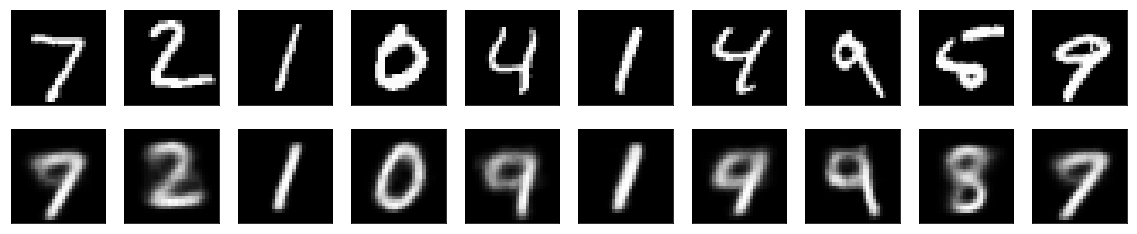

In [11]:
plotCompDecode(xTest, decodeTest, sizeDigit=[28,28])

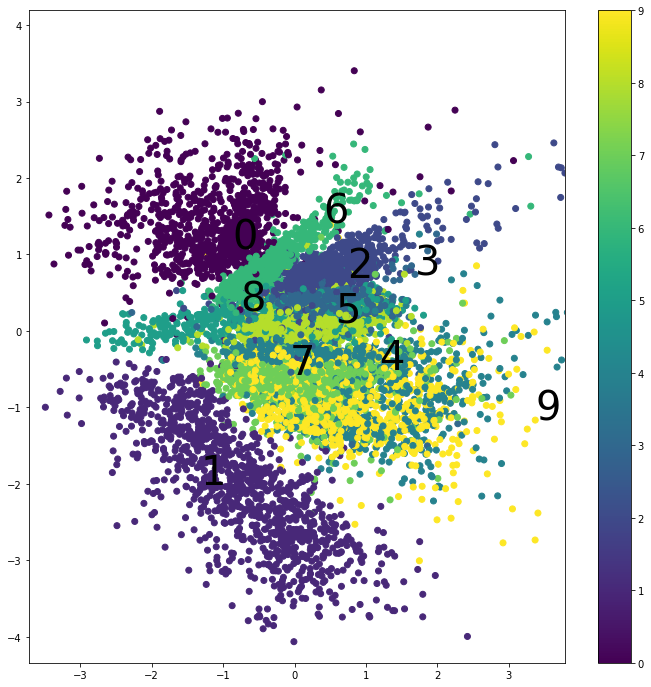

In [12]:
from sklearn.metrics import silhouette_score
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
scoreSilh = silhouette_score(encodeTest, yTest)  

In [15]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, sizeDigit, xlim, ylim)

NameError: name 'decoder' is not defined